In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [62]:
from itertools import chain

In [11]:
import matplotlib.pyplot as plt  # To visualize
import json
from collections import Counter, defaultdict

from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 200)

# Get phonological features PanPhon

In [156]:
# import re
# import unicodedata

# def normalize_ipa(ipa_str):
#     # Convert phonemes to standardized forms
#     ipa_str = re.sub(r'ɑ', 'a', ipa_str)
#     ipa_str = re.sub(r'ɔ', 'o', ipa_str)
#     ipa_str = re.sub(r'ə', 'e', ipa_str)
#     ipa_str = re.sub(r'ɜ', 'e', ipa_str)
#     ipa_str = re.sub(r'ɪ', 'i', ipa_str)
#     ipa_str = re.sub(r'ʊ', 'u', ipa_str)
#     ipa_str = re.sub(r'ɛ', 'e', ipa_str)
#     ipa_str = re.sub(r'ʌ', 'a', ipa_str)
#     ipa_str = re.sub(r'ɒ', 'o', ipa_str)
    
#     # Separating the phonemes from suprasegmental features and representing them separately
#     ipa_str = re.sub(r'[ˈˌ]', '', ipa_str)  # remove stress marks
#     ipa_str = re.sub(r'[ːˑ]', '', ipa_str)  # remove length marks
#     ipa_str = re.sub(r'[̩ ̯ ̪]', '', ipa_str)  # remove syllabic and secondary articulation marks
#     ipa_str = re.sub(r'[̩̯̪]', '', ipa_str)  # remove syllabic and secondary articulation marks
#     ipa_str = re.sub(r'[˥˧˦˨˩˥˧˥˧˩˩˧]', '', ipa_str)  # remove tonal marks
#     ipa_str = re.sub(r'[˨˦˧]', '', ipa_str)  # remove word accent marks
    
#     # Remove non-valid integers
#     ipa_str = re.sub(r'[³⁴⁵⁶⁷⁸⁹⁰]', '', ipa_str)
    
#     # Normalize tones and stress marks
#     ipa_str = re.sub(r'˦˥', '˥', ipa_str)  # normalize tone contours
#     ipa_str = re.sub(r'˨˩', '˩', ipa_str)
#     ipa_str = re.sub(r'ˈ|ˌ', '', ipa_str)  # remove stress marks
    
#     # Remove diacritics and other symbols
#     ipa_str = unicodedata.normalize('NFKD', ipa_str)  # normalize diacritics
#     ipa_str = re.sub(r'[^\w\s]', '', ipa_str)  # remove other symbols
    
#     return ipa_str.strip()  # remove leading/trailing whitespaces

# # Example usage
# ipa_str = "tʃæɪn²z ɔ̃fæ̃ndɪd bai ðiːn tʰruːks"
# normalized_ipa_str = normalize_ipa(ipa_str)
# print(normalized_ipa_str)  # Output: tʃenoz oɛfændid bai dɪn θruks


tʃæin2zofændidbaiðinthruks


To normalize IPA strings in Python as much as possible, you can follow these steps:

1. Convert all characters to lowercase, to ensure consistent comparison and handling of different cases.
2. Use a library like Unidecode to remove any diacritics or other symbols from the characters, to ensure consistency and reduce the number of unique characters.
3. Use a mapping table to convert any non-standard IPA characters to their standardized forms. For example, you can map "ɾ" to "r", or "ɕ" to "ʃ".
4. Separate any suprasegmental features, such as tone, word accents, and stress, from the phonemes themselves, and represent them separately.
5. Remove any non-valid integers, as they are not part of the standard IPA system.
6. Normalize the tone markers, if present, to a consistent format. For example, you can convert "˥" to "5", "˦" to "4", and so on.
7. Finally, you can convert the resulting phoneme strings to a standardized format, such as X-SAMPA, if desired.


In [165]:
import unidecode

# Define mapping table for non-standard IPA characters
ipa_mapping = {
    "ɾ": "r",
    "ɕ": "ʃ",
    # add more mappings as needed
}

def normalize_ipa(ipa_string):
    # Convert to lowercase and remove diacritics
    ipa_string = unidecode.unidecode(ipa_string.lower())
    
    # Map any non-standard IPA characters to their standardized forms
    for key, value in ipa_mapping.items():
        ipa_string = ipa_string.replace(key, value)
    
    # Separate suprasegmental features from phonemes and remove non-valid integers
    phonemes = []
    tones = []
    for char in ipa_string:
        if char.isdigit() and int(char) in range(1, 6):
            tones.append(char)
        elif char.isalpha():
            phonemes.append(char)
    # Normalize tone markers to consistent format
    if tones:
        tones = [f"{int(tone)}" for tone in tones]
    
    # Join phonemes and tones back into a single string
    normalized_ipa = "".join(phonemes + tones)
    
    return normalized_ipa


In [2]:
import panphon
ft = panphon.FeatureTable()

In [3]:
import scipy.stats

In [4]:
df = pd.read_csv("../data/affectiveness/wn_wkb_wikipron.csv")

In [113]:
# import unicodedata

# def normalize_ipa(ipa_string):
#     return  unicodedata.normalize('NFKD', ipa_string).encode('ASCII', 'ignore').decode('utf-8')

In [166]:
df["NORM_PRON"] = df["PRON"].parallel_apply(normalize_ipa)

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_32619/847843684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NORM_PRON"] = df["PRON"].parallel_apply(normalize_ipa)


In [117]:
df = df[["SENSE_LEMMA", "LANG_PRON", "PRON", "NORM_PRON", "V.Mean.Sum","V.SD.Sum",  "A.Mean.Sum", "A.SD.Sum", "D.Mean.Sum", "D.SD.Sum"]]

,SENSE_LEMMA,LANG_PRON,PRON,NORM_PRON,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum,D.Mean.Sum,D.SD.Sum,INIT_NORM_PRON
0,a,hun,ɒː,a,5.040000,1.483333,3.948333,2.381667,5.128333,2.176667,a
1,a,ita,a,a,4.340000,1.820000,3.623333,2.483333,5.096667,1.993333,a
2,aaien,nld,aː i̯ ə n,ain,6.833333,1.446667,4.236667,2.590000,6.256667,1.973333,a
3,aaltoilu,fin,ɑː l t̪ o̞ i̯ l u,altoilu,4.575000,1.745000,4.280000,2.145000,5.170000,2.080000,a
4,aamuhämärä,fin,ɑː m u h æ m æ r æ,amuhaemaerae,6.490000,2.070000,3.650000,2.275000,4.890000,2.445000,a
...,...,...,...,...,...,...,...,...,...,...,...
58943,𐌿𐍂𐍂𐌿𐌽𐍃,got,u r r u n s,urruns,5.395000,1.750000,3.375000,2.535000,5.035000,2.615000,u
58944,𐍃𐌺𐌴𐌹𐌼𐌰,got,s k iː m a,skima,4.935000,1.700000,4.165000,2.195000,5.550000,2.160000,s
58945,𐍅𐌰𐌹𐌽𐌰𐌷𐍃,got,w ɛː n a h s,wenahs,2.220000,1.485000,5.080000,2.720000,3.785000,2.170000,w
58946,𐍅𐍉𐌸𐌴𐌹𐍃,got,w oː θ iː s,wothis,7.505000,1.445000,3.525000,2.720000,6.410000,1.965000,w


In [171]:
df.dropna(subset="NORM_PRON")

,SENSE_LEMMA,LANG_PRON,PRON,NORM_PRON,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum,D.Mean.Sum,D.SD.Sum
0,a,hun,ɒː,a,5.040000,1.483333,3.948333,2.381667,5.128333,2.176667
1,a,ita,a,a,4.340000,1.820000,3.623333,2.483333,5.096667,1.993333
2,aaien,nld,aː i̯ ə n,ain,6.833333,1.446667,4.236667,2.590000,6.256667,1.973333
3,aaltoilu,fin,ɑː l t̪ o̞ i̯ l u,altoilu,4.575000,1.745000,4.280000,2.145000,5.170000,2.080000
4,aamuhämärä,fin,ɑː m u h æ m æ r æ,amuhaemaerae,6.490000,2.070000,3.650000,2.275000,4.890000,2.445000
...,...,...,...,...,...,...,...,...,...,...
58943,𐌿𐍂𐍂𐌿𐌽𐍃,got,u r r u n s,urruns,5.395000,1.750000,3.375000,2.535000,5.035000,2.615000
58944,𐍃𐌺𐌴𐌹𐌼𐌰,got,s k iː m a,skima,4.935000,1.700000,4.165000,2.195000,5.550000,2.160000
58945,𐍅𐌰𐌹𐌽𐌰𐌷𐍃,got,w ɛː n a h s,wenahs,2.220000,1.485000,5.080000,2.720000,3.785000,2.170000
58946,𐍅𐍉𐌸𐌴𐌹𐍃,got,w oː θ iː s,wothis,7.505000,1.445000,3.525000,2.720000,6.410000,1.965000


In [259]:
def get_pron_lang_non_norm(df, lang):
    df = df[df["LANG_PRON"]==lang]
    norm_prons = sorted(list(set(list(chain.from_iterable(df.PRON.tolist())))))
    X_dim = len(df)
    Y_dim = len(norm_prons)
    
    
    pron_matrix = np.zeros((X_dim, Y_dim))  
    for index, pron in enumerate(df["PRON"]):
        ls = [norm_prons.index(x) for x in list(pron)]
        for l in ls:
            pron_matrix[index][l]+=1
    
    df_pron = pd.DataFrame(pron_matrix, columns=norm_prons)
    return df_pron.corrwith(df["V.Mean.Sum"]).to_dict(), X_dim, Y_dim

In [260]:

for lang in list(set(df["LANG_PRON"].tolist())):
    d, x, y = get_pron_lang_non_norm(df, lang)
    v = {k:v for k,v in d.items() if v>0.3 or v<-0.3}
    if len(v)>0:
        print(lang, x,y)
        print(v)

msa 706 49
{'a': 0.7024071171643912, 'b': 0.43797975192048744, 'd': -0.3089150968777928, 'e': 0.4027698619520484, 'h': -0.6139092674274264, 'i': -0.3593564887958937, 's': 0.5689344182072473, 'ɡ': -0.36613177900979404, 'ɾ': -0.36613177900979404, 'ʊ': -0.5004205112069682}
ron 1154 39
{'a': 0.3197862712678595, 'e': -0.45836192748086546, 'n': -0.3147737032412086}
afr 287 41
{'a': 0.7384741354878352, 'k': 0.7384741354878352, 'l': -0.953182239323939, 'm': -0.953182239323939, 'ŋ': 0.7384741354878352, 'ɔ': -0.953182239323939}
glg 654 44
{' ': 0.35471105803973374, 'b': -0.3479728565838916, 'f': 0.360808141753339, 'k': 0.3332863217399324, 'o': 0.31877983682760447, 'ɪ': -0.6872875867117667, 'ɱ': 0.3484098037705862, 'ʃ': -0.6872875867117667, 'β': -0.5430941079832999}
pol 1920 32
{'d': -0.3618313260386163, 'f': -0.3716591675022332, 'j': -0.32166167102133003, 'l': -0.37840262384603424, 'ɛ': -0.3174712035646108}
isl 1174 43
{'c': -0.5961379884514757, 'h': 0.33097169046719643, 'j': 0.327467675957989, 

In [254]:
def get_pron_lang(df, lang):
    df = df[df["LANG_PRON"]==lang]
    norm_prons = sorted(list(set(list(chain.from_iterable(df.NORM_PRON.tolist())))))
    X_dim = len(df)
    Y_dim = len(norm_prons)
    
    
    pron_matrix = np.zeros((X_dim, Y_dim))  
    for index, pron in enumerate(df["NORM_PRON"]):
        ls = [norm_prons.index(x) for x in list(pron)]
        for l in ls:
            pron_matrix[index][l]+=1
    
    df_pron = pd.DataFrame(pron_matrix, columns=norm_prons)
    return df_pron.corrwith(df["V.Mean.Sum"]).to_dict(), X_dim, Y_dim

In [256]:
import warnings
warnings.filterwarnings('ignore')

In [258]:

for lang in list(set(df["LANG_PRON"].tolist())):
    d, x, y = get_pron_lang(df, lang)
    v = {k:v for k,v in d.items() if v>0.3 or v<-0.3}
    if len(v)>0:
        print(lang, x,y)
        print(v)

msa 706 30
{'U': -0.5004205112069682, 'a': 0.7024071171643912, 'b': 0.43797975192048744, 'd': -0.3089150968777928, 'e': 0.4027698619520484, 'g': -0.36613177900979404, 'h': -0.6139092674274264, 'i': -0.3593564887958937, 'r': -0.36613177900979404, 's': 0.5689344182072473}
ron 1154 28
{'a': 0.3197862712678595, 'e': -0.45836192748086546, 'n': -0.3147737032412086}
afr 287 25
{'G': 0.7384741354878352, 'N': 0.7384741354878352, 'a': 0.7384741354878352, 'k': 0.953182239323939, 'l': -0.953182239323939, 'm': -0.953182239323939, 'o': -0.953182239323939}
glg 654 26
{'I': -0.6872875867117667, 'S': -0.6872875867117667, 'b': -0.47013301875394614, 'f': 0.360808141753339, 'k': 0.3332863217399324, 'm': 0.33752136541823624, 'o': 0.35362816526021207}
pol 1920 25
{'d': -0.3618313260386163, 'e': -0.3174712035646108, 'f': -0.3716591675022332, 'j': -0.32166167102133003, 'l': -0.37840262384603424}
isl 1174 28
{'I': -0.6684127021988707, 'c': -0.5961379884514757, 'j': 0.327467675957989, 'k': 0.3077666292763827, '

In [262]:
df[df["LANG_PRON"]=="msa"]

,SENSE_LEMMA,LANG_PRON,PRON,NORM_PRON,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum,D.Mean.Sum,D.SD.Sum,INIT_NORM_PRON
80,abad,msa,a b a t,abat,5.813333,1.536667,3.250000,2.220000,5.480000,2.016667,a
85,abah,msa,a b a h,abah,7.010000,1.975000,3.865000,2.330000,5.655000,2.570000,a
96,abang,msa,a b a ŋ,abaNG,6.990000,1.833333,4.653333,2.506667,6.183333,2.086667,a
133,abdomen,msa,a b d o m ə n,abdomn,4.955000,1.670000,3.590000,2.025000,5.235000,2.025000,a
249,abu,msa,a b u,abu,4.226667,1.626667,3.650000,2.156667,5.070000,1.973333,a
...,...,...,...,...,...,...,...,...,...,...,...
44037,warna,msa,w a ɾ n a,warna,6.375000,1.505000,3.252500,2.015000,5.815000,1.835000,w
44041,warta,msa,w a r t a,warta,5.615000,1.500000,3.995000,2.385000,5.970000,1.975000,w
44226,wilayah,msa,w i l aː y ɑː,wilaya,5.220833,1.486667,3.505000,2.086667,5.466667,1.959167,w
44698,zaman,msa,z a m a n,zaman,5.600000,1.523333,3.406667,2.290000,5.133333,2.103333,z


In [250]:
d = get_pron_lang(df, "deu")

1909 32


In [252]:
d

{'G': -0.0065887225010313345,
 'I': 0.03274400443984691,
 'N': -0.0065887225010313345,
 'R': 0.17544674675446215,
 'S': 0.015482334441585961,
 'U': 0.13566201921409113,
 'Y': -0.04693534864451165,
 'Z': nan,
 'a': -0.19373821918254405,
 'b': -0.14983111292876997,
 'c': -0.057845108077767056,
 'd': -0.05363356775254616,
 'e': -0.1549834151280993,
 'f': -0.19932649037387845,
 'g': -0.11973035495095248,
 'h': 0.02959976177617029,
 'i': 0.04914813459575468,
 'j': nan,
 'k': -0.08621381446807774,
 'l': -0.07541635946105868,
 'm': 0.032247017609984545,
 'n': 0.1662628882896629,
 'o': 0.038791168871116284,
 'p': 0.17557079039532697,
 'r': -0.2211074099299225,
 's': -0.018742714348344385,
 't': -0.028331397294441805,
 'u': 0.13380748767392783,
 'v': 0.06850146778507706,
 'x': 0.13646325600082695,
 'y': 0.09296244702017863,
 'z': 0.09288594329255082}

# INITIAL PRON

In [235]:
df["INIT_NORM_PRON"] = df["NORM_PRON"].str[0]

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_32619/949551908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["INIT_NORM_PRON"] = df["NORM_PRON"].str[0]


In [236]:
df = df.dropna(subset=["INIT_NORM_PRON"])

In [237]:
norm_prons_init = sorted(list(set((df.INIT_NORM_PRON.tolist()))))

In [238]:
X_dim = len(df)
Y_dim = len(norm_prons_init)

In [239]:
X_dim, Y_dim

(58946, 36)

In [240]:
pron_matrix = np.zeros((X_dim, Y_dim))  
for index, pron in enumerate(df["INIT_NORM_PRON"]):
    ls = [norm_prons_init.index(x) for x in list(pron)]
    for l in ls:
        pron_matrix[index][l]+=1

In [241]:
df_pron = pd.DataFrame(pron_matrix, columns=norm_prons_init)

In [243]:
df_pron.corrwith(df["V.Mean.Sum"])

F    0.001101
I   -0.011921
N    0.005499
O    0.001876
R   -0.004095
S    0.002044
U   -0.004245
W    0.007163
Y   -0.003132
Z    0.009224
a    0.008366
b   -0.009529
c    0.003415
d   -0.030597
e    0.009989
f   -0.004694
g   -0.000288
h    0.002747
i   -0.016674
j    0.022711
k    0.014002
l    0.015629
m    0.005498
n   -0.003304
o   -0.006526
p   -0.001180
q    0.000105
r   -0.006728
s    0.007402
t   -0.007841
u   -0.002442
v    0.009831
w    0.002888
x   -0.000831
y    0.002686
z   -0.009815
dtype: float64

In [225]:
norm_prons = sorted(list(set(list(chain.from_iterable(df.PRON.tolist())))))

In [226]:
X_dim = len(df)
Y_dim = len(norm_prons)

In [227]:
X_dim, Y_dim

(58948, 207)

In [229]:
pron_matrix = np.zeros((X_dim, Y_dim))  
for index, pron in enumerate(df["PRON"]):
    ls = [norm_prons.index(x) for x in list(pron)]
    for l in ls:
        pron_matrix[index][l]+=1

In [230]:
np.nonzero(pron_matrix)

(array([    0,     0,     1, ..., 58947, 58947, 58947]),
 array([ 79, 144,   1, ...,  12,  14,  21]))

In [231]:
df_pron = pd.DataFrame(pron_matrix, columns=norm_prons)

In [233]:
df_pron.corrwith(df["V.Mean.Sum"]).to_dict()

{' ': -0.04404203814027156,
 'a': 0.0029013240525574127,
 'b': -0.012516980404204237,
 'c': 0.010302195209198395,
 'd': -0.029054996166389343,
 'e': -0.008526567062957745,
 'f': -0.023794996106548255,
 'g': 0.003845525467613792,
 'h': 0.0009014843090953474,
 'i': 0.006359859213951094,
 'j': 0.014676710516837265,
 'k': -0.01601556328039646,
 'l': -0.0038818597213491996,
 'm': 0.0004522570043625527,
 'n': 0.00717039784539506,
 'o': -0.027922482239055867,
 'p': -0.019512797334663944,
 'q': 0.0025746592045896217,
 'r': -0.020975041987786047,
 's': -0.015376584322270168,
 't': -0.008460123247933484,
 'u': -0.016440079142042523,
 'v': 0.0020468111494608508,
 'w': -8.203726791870872e-05,
 'x': -0.007681843127839473,
 'y': -0.02165703611526824,
 'z': -0.018925731986318684,
 '~': 0.007420981054670835,
 '²': 0.00446174788582873,
 '³': -0.008583935371341564,
 '¹': -0.003766321341715154,
 'à': 0.004572881069457934,
 'á': 0.008706296469656708,
 'â': 0.006715950360035729,
 'ã': -0.009231955573927815

# get the matrix of (LEN_DF, NUM_PRONS)

In [178]:
norm_prons = sorted(list(set(list(chain.from_iterable(df.NORM_PRON.tolist())))))

In [179]:
X_dim = len(df)
Y_dim = len(norm_prons)

In [180]:
X_dim, Y_dim

(58948, 43)

In [181]:
len(norm_prons)

43

In [192]:
pron_matrix = np.zeros((X_dim, Y_dim))  
for index, pron in enumerate(df["NORM_PRON"]):
    ls = [norm_prons.index(x) for x in list(pron)]
    for l in ls:
        pron_matrix[index][l]+=1

In [194]:
np.nonzero(pron_matrix)

(array([    0,     1,     2, ..., 58947, 58947, 58947]),
 array([17, 17, 17, ..., 28, 30, 37]))

In [196]:
valence = df["V.Mean.Sum"].to_numpy()

In [197]:
valence

array([5.04      , 4.34      , 6.83333333, ..., 2.22      , 7.505     ,
       6.895     ])

In [198]:
df_pron = pd.DataFrame(pron_matrix, columns=norm_prons)

In [202]:
df_pron = df_pron.replace(0, np.nan)

In [223]:
df_1 = pd.concat([df_pron["1"], df["V.Mean.Sum"]], axis=1).dropna()

In [224]:
df_1.corrwith(df_1["V.Mean.Sum"])

1             0.035897
V.Mean.Sum    1.000000
dtype: float64

In [220]:
df_pron.corrwith(df["V.Mean.Sum"])

1    0.035897
2   -0.000296
3    0.025427
4   -0.075752
5   -0.117080
E         NaN
F   -0.203325
G   -0.001647
I   -0.000488
N    0.028622
O         NaN
R   -0.015929
S    0.028259
U    0.005407
W   -0.071798
Y    0.032788
Z   -0.008210
a   -0.009272
b    0.012623
c    0.031958
d   -0.027856
e   -0.000786
f    0.027679
g    0.030879
h    0.001503
i   -0.009954
j   -0.006404
k   -0.022850
l   -0.021103
m    0.009310
n   -0.014419
o   -0.001971
p    0.010822
q    0.082079
r   -0.024596
s   -0.006347
t    0.010016
u   -0.022467
v   -0.000422
w   -0.024649
x   -0.002043
y   -0.036334
z    0.004819
dtype: float64

In [75]:
df_eng = df[df["LANG_PRON"]=="eng"]
prons_eng = df_eng["PRON"].str.split().tolist()
prons_eng = list(set(list(chain.from_iterable(prons_eng))))

In [76]:
len(prons_eng)

65

In [108]:
import unidecode

In [112]:
for x in sorted(prons_eng):
    print(x, unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

a a
aː a
b b
d d
d͡ʒ d
e e
f f
h h
i i
iː i
j j
k k
l l
l̩ l
m m
m̩ m
n n
n̩ n
o o
p p
r r
s s
t t
tʰ th
t̚ t
t̬ t
t͡ʃ t
u u
uː u
v v
w w
z z
æ 
ð 
ŋ 
ɑ 
ɑː 
ɒ 
ɔ 
ɔː 
ə 
əː 
ə̯ 
ɚ 
ɛ 
ɛː 
ɜ 
ɜː 
ɝ 
ɡ 
ɨ 
ɪ 
ɪː 
ɪ̯ 
ɫ 
ɹ 
ɾ 
ʃ 
ʊ 
ʊ̯ 
ʌ 
ʍ 
ʒ 
ʔ 
θ 


In [78]:
sorted(prons_eng)

['a',
 'aː',
 'b',
 'd',
 'd͡ʒ',
 'e',
 'f',
 'h',
 'i',
 'iː',
 'j',
 'k',
 'l',
 'l̩',
 'm',
 'm̩',
 'n',
 'n̩',
 'o',
 'p',
 'r',
 's',
 't',
 'tʰ',
 't̚',
 't̬',
 't͡ʃ',
 'u',
 'uː',
 'v',
 'w',
 'z',
 'æ',
 'ð',
 'ŋ',
 'ɑ',
 'ɑː',
 'ɒ',
 'ɔ',
 'ɔː',
 'ə',
 'əː',
 'ə̯',
 'ɚ',
 'ɛ',
 'ɛː',
 'ɜ',
 'ɜː',
 'ɝ',
 'ɡ',
 'ɨ',
 'ɪ',
 'ɪː',
 'ɪ̯',
 'ɫ',
 'ɹ',
 'ɾ',
 'ʃ',
 'ʊ',
 'ʊ̯',
 'ʌ',
 'ʍ',
 'ʒ',
 'ʔ',
 'θ']

In [70]:
df_deu = df[df["LANG_PRON"]=="deu"]

In [72]:
prons_deu = df_deu["PRON"].str.split().tolist()
prons_deu = list(set(list(chain.from_iterable(prons_deu))))

In [73]:
prons_deu

['l',
 'ʒ',
 'd͡ʒ',
 'ɛː',
 's',
 'p͡f',
 'ɪ',
 'ʀ',
 'tʰ',
 'pʰ',
 'oː',
 'tː',
 'χ',
 'p',
 't͡s',
 'ɡ',
 'ʁ',
 'f',
 'nː',
 'iː',
 'ə',
 'a͜i',
 'b',
 'aˑ',
 'ɔ',
 'ʔ',
 'øː',
 'eː',
 'n',
 'aː',
 'ɱ̩',
 'ʏ̯',
 'a',
 'uː',
 'ɪ̯',
 'ɔ̃ː',
 't̪ʰ',
 'u̯',
 'i̯',
 'y',
 'ɛ̃ː',
 't͡ʃ',
 'h',
 'm',
 'ŋ',
 'o',
 'ʊ',
 'ɔ̃',
 'ɐ̯',
 'sː',
 'ɐ',
 'i',
 'ɦ',
 'ãː',
 'ɑ',
 'yː',
 'd',
 'k',
 'ŋ̍',
 'kʰ',
 'ç',
 'ʏ',
 'z',
 'x',
 'n̩',
 'j',
 'e',
 'ɪ̯̯',
 'ʃ',
 'ɛ',
 'ŋ̩',
 'u',
 't',
 'ʊ̯',
 'v',
 'r',
 'l̩',
 'œ']

In [ ]:
pron

In [59]:
prons = df["PRON"].str.split().tolist()

In [66]:
pronsls = list(set(list(chain.from_iterable(prons))))

In [68]:
len(pronsls)

705

In [69]:
pronsls

['a̠',
 'kʰʲ',
 'a̯',
 't͡s̺',
 'e̯',
 'ɸː',
 'ī',
 'ɨ̥ᵝ',
 'ɾː',
 'vʲ',
 's̪ʲ',
 's',
 'ɶ',
 'ɱ',
 'ɯᵝ',
 'ʌ̤',
 'rˠ',
 'p͡f',
 'æ̌ˑ',
 'd̪ʱ',
 'aʲ',
 'ɵ',
 'âː',
 'n̪ʲ',
 'ɫː',
 'ɦʲ',
 'ɛ̂',
 '⁽ʲ',
 'ó',
 'ũː',
 'ʊ̯ˑ',
 'òː',
 'ã̠',
 'ʌ̃',
 'ˀɤ',
 'pʰ',
 'y̯',
 'ɗ',
 'tː',
 't͡ʃʰ',
 'ɐ́',
 'χ',
 'p',
 'ɑˀ',
 'nˀ',
 'ð̞',
 'ḭ',
 'ɡ',
 'ɯ̟̃ᵝ',
 'ɛ̂ˑ',
 'qʼ',
 'aːˀ',
 'dˤ',
 'ḛ',
 'w̜',
 'f',
 'd̪̚',
 'kʷ',
 '˧˦',
 'q',
 'ɰ̃',
 'ɝ',
 'iː',
 'lʲː',
 'ɾᵊ',
 '⁴',
 'ǐː',
 'u͡ə',
 'ɛ̂ː',
 'ěː',
 'ʃʰ',
 'dʱ',
 'ë',
 'aˑ',
 'ʐ̩',
 'ɤ',
 'ʌ̹ː',
 'kʲ',
 'ˀɑ',
 'ʊ́',
 'dː',
 'ʔ',
 'g̊',
 'e̝',
 'ʒː',
 'ɡ̊',
 'ɨᵝ',
 'ʏː',
 'fˠ',
 'jː',
 'pː',
 'aː',
 'lʷ',
 'ɱ̩',
 'ɪ̃',
 'm̥',
 'ɪ̯',
 'k̚',
 'á',
 'bʲ',
 'r̩̂',
 'jᵊ',
 'íːⁿ',
 'ɑ̀',
 'ʉ̟ː',
 'ħ',
 'ŋ',
 'o',
 'éː',
 'ɔˀ',
 'ɟː',
 'ä̂ˑ',
 'øːʰ',
 'ʈʲ',
 'ʊ',
 'n̪ˠ',
 'ǔː',
 'ǎ',
 'ẽ̞ː',
 'ǃʰ',
 'ɛ̌ː',
 'íⁿ',
 'uʰ',
 'kːʰ',
 'ɳː',
 'ɐ̯',
 'tʷ',
 'o̞̯',
 'l̥',
 'ũ̯',
 'fː',
 'm̩',
 'ŏ',
 'd͡ʒː',
 'i',
 'β',
 'ɦ',
 'øˀ',
 '˩˩˦',
 'l̪ʲ',
 'î',
 'ɛ̝ː',


In [51]:
dfy = df[df["PRON"].str.contains("y")]

In [54]:
dfi = df[df["PRON"].str.contains("i")]

In [56]:
dfo = df[df["PRON"].str.contains("o")]

<Axes: xlabel='V.Mean.Sum', ylabel='Count'>

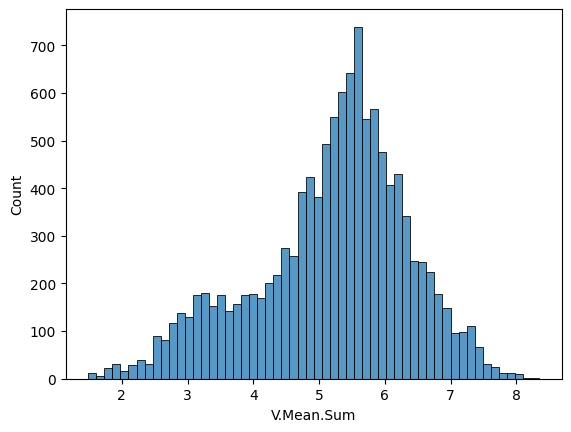

In [57]:
sns.histplot(data=dfo, x="V.Mean.Sum")

<Axes: xlabel='V.Mean.Sum', ylabel='Count'>

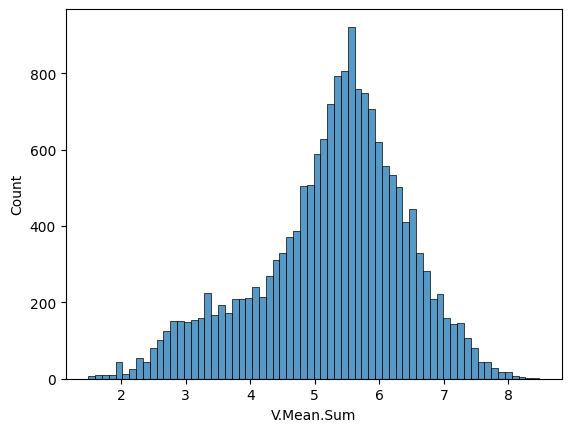

In [55]:
sns.histplot(data=dfi, x="V.Mean.Sum")

<Axes: xlabel='V.Mean.Sum', ylabel='Count'>

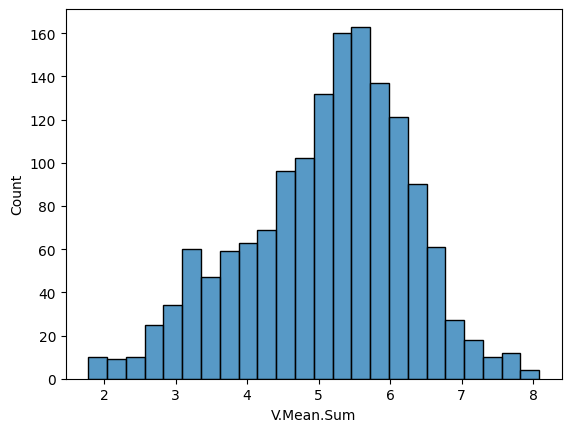

In [53]:
sns.histplot(data=dfy, x="V.Mean.Sum")

In [44]:
df["Initial"] = df["PRON"].str.split(expand=True)[0]

In [45]:
df["Initial"].value_counts().to_dict()

{'k': 5754,
 'p': 4717,
 's': 4357,
 'm': 3422,
 'b': 2987,
 'a': 2394,
 't': 2307,
 'd': 2007,
 'f': 1983,
 'l': 1701,
 'v': 1498,
 'r': 1430,
 'ɡ': 1322,
 'n': 1191,
 'i': 1079,
 'h': 1066,
 'ʃ': 821,
 'e': 820,
 'z': 763,
 'ʔ': 590,
 'j': 570,
 't͡ɕ': 556,
 't̪': 534,
 'ʋ': 526,
 'ʁ': 523,
 'ɔ': 500,
 'ɛ': 485,
 'o': 473,
 'ɪ': 431,
 't͡ʃ': 429,
 'x': 426,
 'u': 406,
 'kʰ': 369,
 'tʰ': 353,
 'ɑ': 348,
 'd͡ʒ': 318,
 'w': 317,
 'd̪': 291,
 'pʰ': 287,
 'ə': 245,
 's̠': 237,
 't͡s': 230,
 'ɦ': 228,
 'ʒ': 213,
 'ĩ': 211,
 'ɹ': 207,
 'ɣ': 203,
 'sʰ': 202,
 'ɕ': 200,
 'ʂ': 196,
 'ɐ': 187,
 't͡ɕʰ': 160,
 'ẽ': 151,
 'c': 144,
 'aː': 134,
 'ɛ̃': 133,
 '²': 131,
 'ʊ': 124,
 's̪': 123,
 'ɾ': 122,
 'sˠ': 117,
 'ɟ': 113,
 'æ': 110,
 'ʈ͡ʂ': 108,
 'y': 107,
 'ɲ': 105,
 'bˠ': 103,
 'ɑ̃': 99,
 'eː': 96,
 'o̞': 92,
 'θ': 90,
 'e̞': 86,
 'ʈ͡ʂʰ': 84,
 'bʲ': 79,
 'dʲ': 72,
 'mʲ': 70,
 'pʲ': 70,
 't̪ˠ': 68,
 'n̪': 68,
 'd̪ˠ': 67,
 'uː': 67,
 'ʐ': 67,
 'tʲ': 66,
 'ʌ': 66,
 'fˠ': 61,
 'ɑː': 60,
 'ħ': 58,
 '

In [46]:
df_m = df[df["Initial"]=="m"]
coeff_count(df_m, "Initial")

(1572,)
(1572,)


(0.10723510457849404, 2.038653556636954e-05)

In [48]:
df_b = df[df["Initial"]=="b"]
coeff_count(df_b, "Initial")

(1487,)
(1487,)


(0.0773462327914639, 0.002839854681650773)

In [49]:
df_p = df[df["Initial"]=="p"]
coeff_count(df_p, "Initial")

(1949,)
(1949,)


(0.0633205238709595, 0.005166665927255)

In [264]:
def get_phon_features(phone):
    r = ft.word_to_vector_list(phone, numeric=True)
    r_arr = np.array(r)
    seg_len = r_arr.shape[0]
    
    r_initials = r[0]
    r_values = np.count_nonzero(r_arr==1, axis=0)/seg_len
    
    rs = np.concatenate((r_initials, r_values), axis=0)
    return pd.Series(rs)

In [265]:
features = ["syl", "son", "cons", "cont", "delrel", "lat", "nas", "strid", "voi", "sg", "cg", "ant", 
            "cor", "distr", "lab", "hi", "lo", "back", "round", "velaric", "tense", "long", "hitone", "hireg"]

In [266]:
Initial_features = [f"init_{x}" for x in features]
all_features = Initial_features+features

In [267]:
df[all_features]= df["PRON"].parallel_apply(get_phon_features)

In [269]:
df.to_csv("../data/affectiveness/wn_wkb_wikipron_features.csv", index=False)

<Axes: xlabel='V.Mean.Sum', ylabel='Count'>

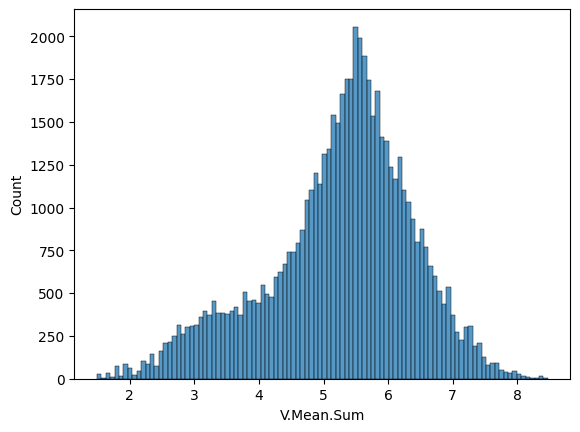

In [14]:
sns.histplot(data=df, x="V.Mean.Sum")

In [42]:
def coeff_count(df, feature):
    X_df = pd.DataFrame.from_dict(df.groupby("V.Mean.Sum").agg("count")[feature].to_dict(), orient="index").rename(columns={0:f"#{feature}"})
    X = X_df.index.values
    print(X.shape)
    Y = X_df[f"#{feature}"].values
    print(Y.shape)
    pr = scipy.stats.pearsonr(X,Y)
    return pr.statistic, pr.pvalue

In [38]:
df["Count"] = df["PRON"].str.split().str.len()

In [39]:
df

,SENSE_LEMMA,LANG_PRON,PRON,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum,D.Mean.Sum,D.SD.Sum,init_syl,init_son,init_cons,init_cont,init_delrel,init_lat,init_nas,init_strid,init_voi,init_sg,init_cg,init_ant,init_cor,init_distr,init_lab,init_hi,init_lo,init_back,init_round,init_velaric,init_tense,init_long,init_hitone,init_hireg,syl,son,cons,cont,delrel,lat,nas,strid,voi,sg,cg,ant,cor,distr,lab,hi,lo,back,round,velaric,tense,long,hitone,hireg,Count
0,a,hun,ɒː,5.040000,1.483333,3.948333,2.381667,5.128333,2.176667,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0,1
1,a,ita,a,4.340000,1.820000,3.623333,2.483333,5.096667,1.993333,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1
2,aaien,nld,aː i̯ ə n,6.833333,1.446667,4.236667,2.590000,6.256667,1.973333,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.500000,1.000000,0.250000,0.750000,0.0,0.000000,0.250000,0.000000,1.000000,0.0,0.0,0.250000,0.250000,0.000000,0.000000,0.250000,0.250000,0.250000,0.000000,0.0,0.500000,0.250000,0.0,0.0,4
3,aaltoilu,fin,ɑː l t̪ o̞ i̯ l u,4.575000,1.745000,4.280000,2.145000,5.170000,2.080000,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.428571,0.857143,0.428571,0.857143,0.0,0.285714,0.000000,0.000000,0.857143,0.0,0.0,0.428571,0.428571,0.142857,0.142857,0.285714,0.142857,0.428571,0.285714,0.0,0.571429,0.142857,0.0,0.0,7
4,aamuhämärä,fin,ɑː m u h æ m æ r æ,6.490000,2.070000,3.650000,2.275000,4.890000,2.445000,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.555556,1.000000,0.444444,0.777778,0.0,0.000000,0.222222,0.000000,0.888889,0.0,0.0,0.333333,0.111111,0.000000,0.333333,0.111111,0.444444,0.222222,0.111111,0.0,0.555556,0.111111,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58943,𐌿𐍂𐍂𐌿𐌽𐍃,got,u r r u n s,5.395000,1.750000,3.375000,2.535000,5.035000,2.615000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.333333,0.833333,0.666667,0.833333,0.0,0.000000,0.166667,0.000000,0.833333,0.0,0.0,0.666667,0.666667,0.000000,0.333333,0.333333,0.000000,0.333333,0.333333,0.0,0.333333,0.000000,0.0,0.0,6
58944,𐍃𐌺𐌴𐌹𐌼𐌰,got,s k iː m a,4.935000,1.700000,4.165000,2.195000,5.550000,2.160000,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.400000,0.600000,0.600000,0.600000,0.0,0.000000,0.200000,0.000000,0.600000,0.0,0.0,0.400000,0.200000,0.000000,0.200000,0.400000,0.200000,0.200000,0.000000,0.0,0.400000,0.200000,0.0,0.0,5
58945,𐍅𐌰𐌹𐌽𐌰𐌷𐍃,got,w ɛː n a h s,2.220000,1.485000,5.080000,2.720000,3.785000,2.170000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.333333,0.833333,0.500000,0.833333,0.0,0.000000,0.166667,0.000000,0.666667,0.0,0.0,0.333333,0.333333,0.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.166667,0.166667,0.0,0.0,6
58946,𐍅𐍉𐌸𐌴𐌹𐍃,got,w oː θ iː s,7.505000,1.445000,3.525000,2.720000,6.410000,1.965000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.400000,0.600000,0.400000,1.000000,0.0,0.000000,0.000000,0.000000,0.600000,0.0,0.0,0.400000,0.400000,0.200000,0.200000,0.400000,0

In [43]:
coeff_count(df, "Count")

(6954,)
(6954,)


(0.04007809022486302, 0.0008291371997596479)

In [21]:
df_features = df[features]
df_init_features = df[Initial_features]

In [36]:
df_features.corrwith(df["V.Mean.Sum"])

syl        0.023640
son        0.034554
cons      -0.036083
cont       0.000621
delrel     0.011352
lat        0.003663
nas        0.020103
strid     -0.012020
voi        0.010163
sg         0.004489
cg         0.003811
ant       -0.017480
cor       -0.007102
distr      0.003351
lab       -0.015573
hi         0.006160
lo         0.007505
back      -0.019890
round     -0.024717
velaric    0.004411
tense      0.002596
long       0.026862
hitone     0.010494
hireg      0.007295
dtype: float64

In [37]:
df_init_features.corrwith(df["V.Mean.Sum"])

init_syl       -0.006435
init_son        0.011240
init_cons      -0.002149
init_cont       0.011786
init_delrel     0.003551
init_lat        0.018143
init_nas       -0.005368
init_strid      0.000985
init_voi       -0.007835
init_sg         0.004491
init_cg         0.011803
init_ant       -0.021523
init_cor       -0.011701
init_distr      0.010644
init_lab       -0.003099
init_hi         0.007704
init_lo         0.006112
init_back       0.001942
init_round     -0.009338
init_velaric         NaN
init_tense     -0.001210
init_long       0.024967
init_hitone          NaN
init_hireg           NaN
dtype: float64

In [32]:
def plot_heatmap(df):
    corr = df.corr().dropna(axis=1, how="all").dropna(axis=0, how="all")
    f, ax = plt.subplots(figsize=(20,15))
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230,20, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

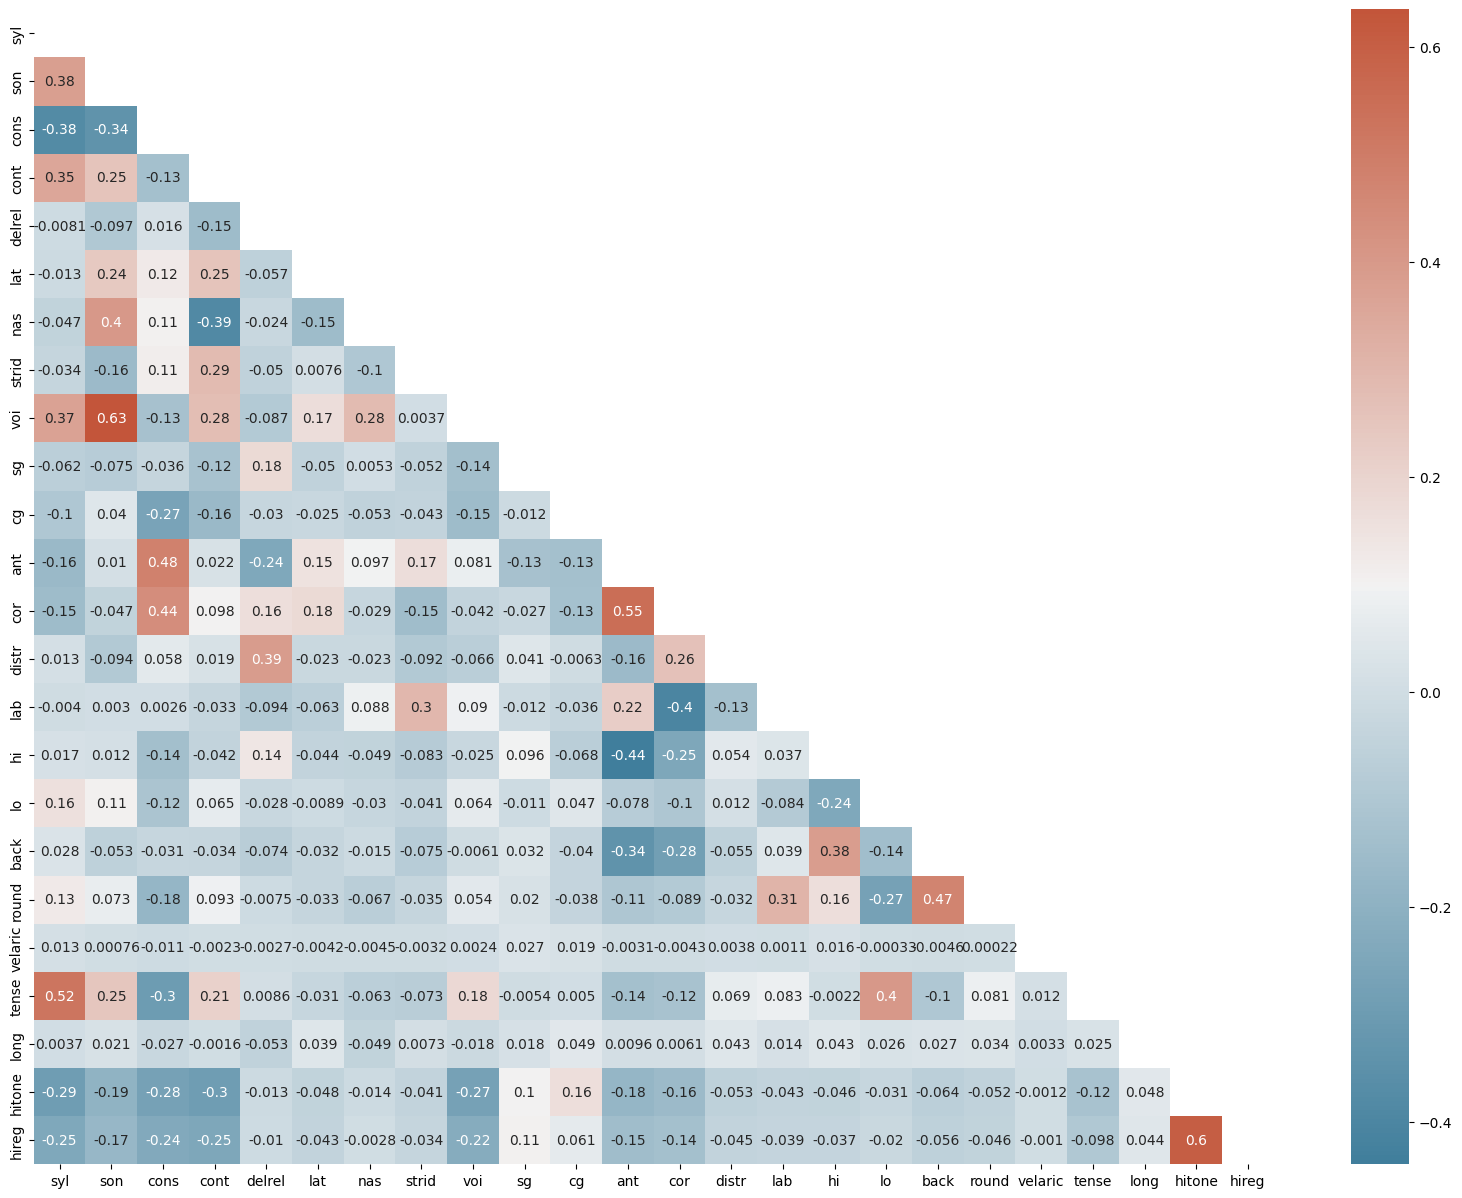

In [33]:
plot_heatmap(df_features)

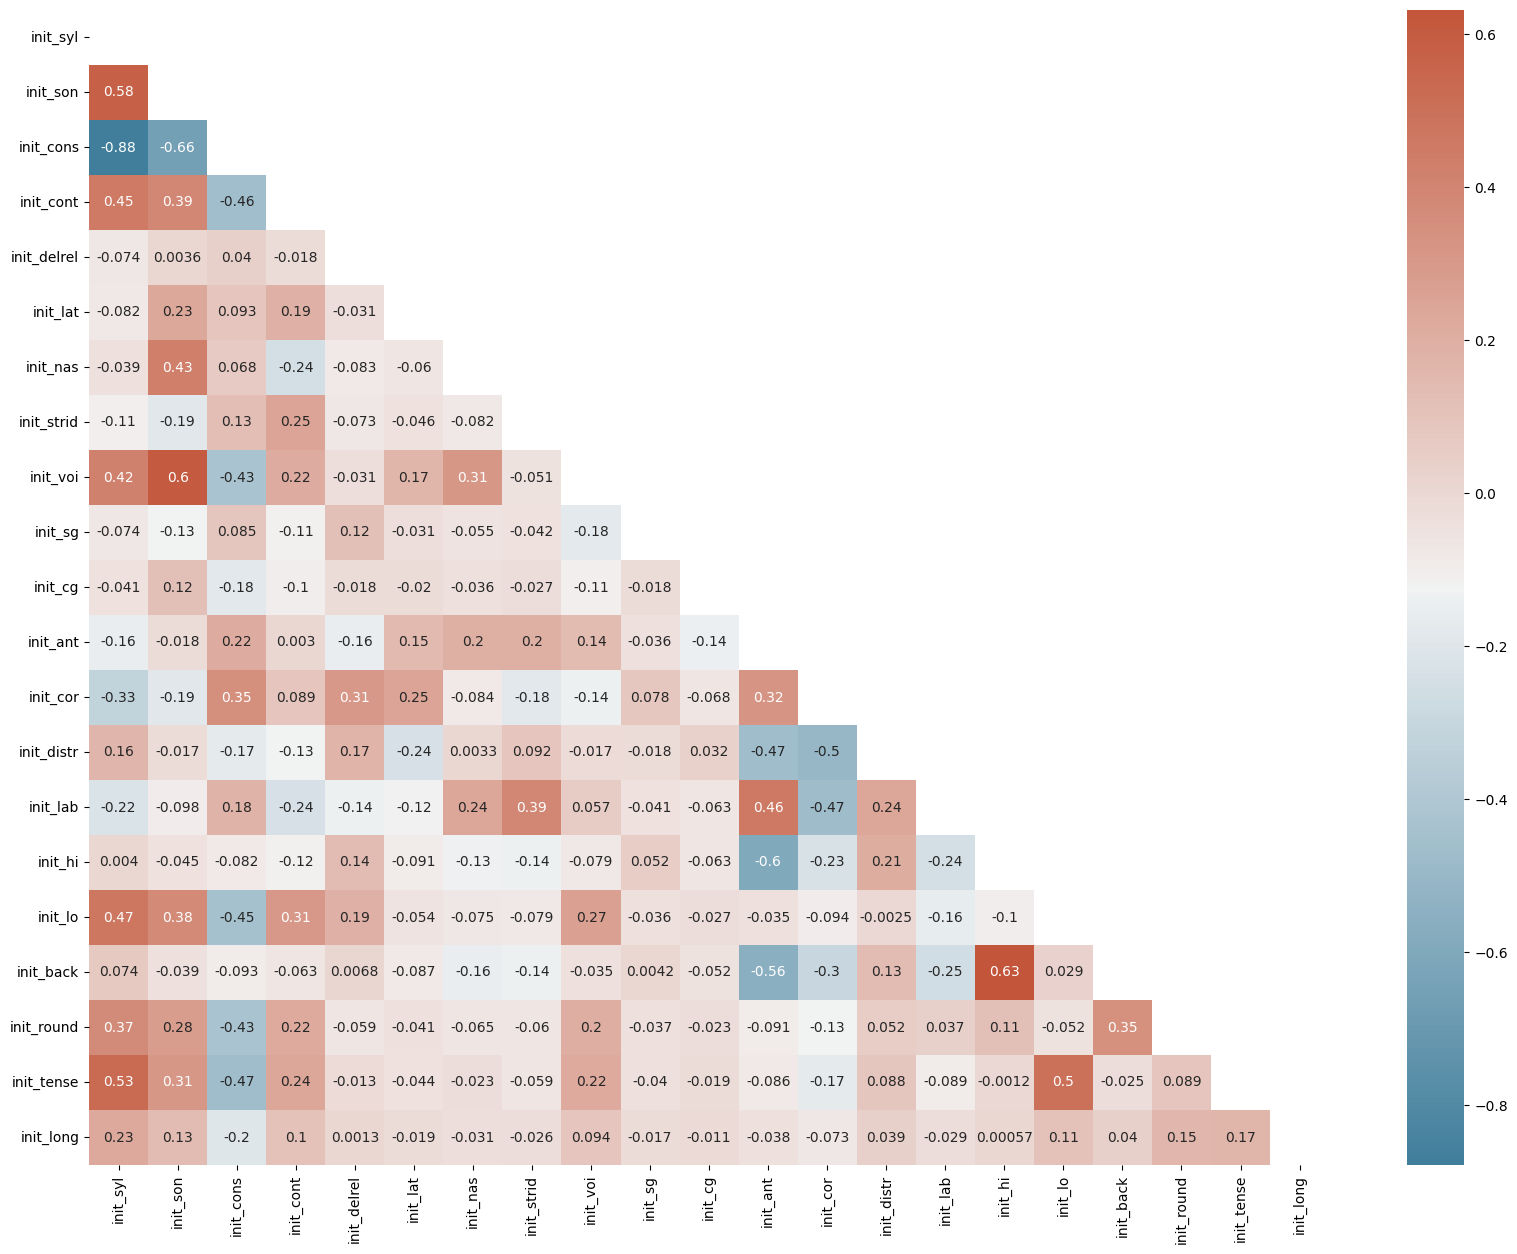

In [34]:
plot_heatmap(df_init_features) # (syl, son, cons, cont) significantly correlate with conc.